## Announcements

Happy New Year! I’m finally back to FastAI after taking a break due to job applications, trying to learn Golang and reflecting on my job search. This lesson was particularly challenging for me because I ran into a bunch of weird bugs and updates to the hugging face transformer API. I had no idea what the code was doing in the FastAI example despite copying Jeremy’s code verbatim and printing print statements. After spending some time trying to debug and understand what each part of the code setup was doing with hugging face and Jeremy’s code I finally feel comfortable trying to write a blog post about this lesson.

## Acknowledgements

All of this code was written by Jeremy Howard and the FastAI team. I modified it slightly to include my own print statements, comments and additional helper functions based on Jeremy’s code. This is the source for the original code [Getting Start With NLP for Absolute Begginers](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners) and [Iterate Like A Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/).


## Summary

In this lesson, Jeremy gives an overview of his pioneering work with ULMFit, how to use Transformers and the set up for participating on kaggle.

I’m no NLP expert and don’t have an interest in NLP but what really excited me was that I finally understood what the iteration and development process was for a Kaggle Competition. This had been one of my goals when I embarked on FastAI.

## Jeremy Howard's Advice

Know the tools for your trade really well
- **Data Science Core Tools**: Python, Numpy, Pandas Matplotlib, ScikitLearn, Pytorch, Scipy

## Data Science/Kaggle Competition Workflow

This is the workflow that I figured out from this chapter.

1. Import data and check files
3. Exploratory Data Analysis
4. Data Representation (Wrangling, Tokenization, Numericalization)
5. Metrics
6. Training Model
7. Evaluate Model Performance

I found the steps similar to the visualization process and could have dedicated some more time to iterating and fine-tuning my model for scoring high on this kaggle competition but in this chapter I was aiming to get an understanding of the general workflow and process that goes into building and iterating a model.

## US Patent Phrase to Phrase Matching Competition

The US Patent Phrase to Phrase Matching Kaggle Competition is used as the case study for learning the basics of NLP, how to use transformers and the kaggle workflow. More information about the data and competition can be found here [US Patent Phrase to Phrase Matching Competition](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/)

## Load Data and Libraries

In [1]:
# import libraries and files

# required libraries + packages for any ml/data science project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# fastai library contains all the packages above and wraps them in the fastai library
!pip install -Uqq fastai

# kaggle API package install
!pip install kaggle

# Hugging Face required libraries + packages
!pip install -q datasets
!pip install transformers sentencepiece
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.2 MB/s eta 0:00:00


In [2]:
# import stuff from fastai
from fastai.imports import *
import os
from pathlib import Path
import zipfile


'''Function for loading kaggle datasets locally or on kaggle
Returns a local path to data files
- input: Kaggle API Login Credentials, Kaggle Contest Name '''
def loadData(creds, dataFile):
    # variable to check whether we're running on kaggle website or not
    iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

    # path for kaggle API credentials
    cred_path = Path('~/.kaggle/kaggle.json').expanduser()

    if not cred_path.exists():
        cred_path.parent.mkdir(exist_ok=True)
        cred_path.write_text(creds)
        cred_path.chmod(0o600)

    # Download data from Kaggle to path and extract files at path location

    # local machine
    path = Path(dataFile)
    if not iskaggle and not path.exists():
        import kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

    # kaggle
    if iskaggle:
        fileName = '../input/' + dataFile
        path = fileName

    return path

In [3]:
creds = ''
dataFile = 'us-patent-phrase-to-phrase-matching'
path = loadData(creds, dataFile)

100%|██████████| 682k/682k [00:00<00:00, 727kB/s]

**Document** - A file containing some text

**Large Documents** - One text file per document, often organized into one folder per category

**Smaller Documents** - One document per row in a CSV File

In [4]:
# check data files
!ls {path}

sample_submission.csv  test.csv  train.csv


## Problem Statement

`Problem`
given a pairs of phrases (an `anchor` or `target` phrase), rate how similar they are on a scale of `0`(not similar) to `1`(identical in meaning). Similarity has been scored within a patent's `context` specifically the `CPC Classification` which indicates the subject to which the patent relates.

`Training Data`

- contains phrases, contexts and similarity scores

`Test(Inference) Data`

 - unseen test contains approximately `12k` pairs of phrases. Small public test set has been provided for testing purposes **but is not use in scoring**.

 - contains identitical structure to `training data` **but without the score**

`Evaluation Goal`

- Build model to match phrases in order to extract contextual information helping the patent community connect the dots between millions of patent documents

`Evaluation Metric`

- Submissions are evaluated on the `Pearson Correlation Coefficient` between **predicted** and **actual** similarity scores.

`Submission Format`

- id(representing a pair of phrases) in test set, score representing the similarity score


- A score of 1 is considered that the two inputs have identical meaning
- A score of 0 is considered that the two inputs have totally different meaning
- A score in between ie. 0.5 means they're somewhat similar but not identical

- Problem Type - NLP Classification Problem -> classify document automatically into some category

## Exploratory Data Analysis

In [5]:
# set up data path

# training data path
df = pd.read_csv(path/'train.csv')

# testing data path
eval_df = pd.read_csv(path/'test.csv')

# sample submission data path
submit_df = pd.read_csv(path/'sample_submission.csv')


In [6]:
# Test Data Length
print(f"{len(df)}")

36473


In [7]:
# Training Data Info
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [8]:
# Training Data Summary
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [9]:
# Test Data Length
print(f"{len(eval_df)}")

36


In [10]:
# Test Data Info
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [11]:
# Test Data Summary
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


## Data Representation (Tokenization, Numericalization, Data Wrangling)

Models require numbers as inputs -> need some strategy of mapping words, characters etc to a numerical value

**Tokenization**: Split each text up into tokens

**Numericalization**: Convert each token to a number

**Autokenizer**:function for creating a tokenizer appropriate for the selected NLP model

**Vocab**: A special list in the tokenizer which contains a unique integer for every possible token string

The start of a new word is indicated by __


In [12]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer
import datasets
from datasets import load_dataset, Dataset, DatasetDict

# ignore hugging face warnings
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [13]:
# Tokenization + Numericalization

# - Models require numbers as inputs -> need to convert text to numbers:
# Tokenization - split each text into tokens
# Numericalization - convert each word into a number
# - This process depends on the model that is used. AutoTokenizer creates the appropriate tokenizer based on the selected model

# Model
# - This is a reasonable model to start nearly NLP problem. Replace small with large for a slower but more accurate model
# once data exploration and experimentation is completed
model_nm = 'microsoft/deberta-v3-small'

# Tokenizer
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

# Test Tokenizer
print(f"Favorite Line from The Bear: {tokz.tokenize('Every Second Counts')}")
print(f"Uncommon words: {tokz.tokenize('A platypus is an ornithorhynchus anatinus.')}")

# function for tokenizing
def tok_func(x):
  return tokz(x["input"])

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Favorite Line from The Bear: ['▁Every', '▁Second', '▁Counts']
Uncommon words: ['▁A', '▁platypus', '▁is', '▁an', '▁or', 'ni', 'tho', 'rhynch', 'us', '▁an', 'at', 'inus', '.']


In [14]:
# Combine Context + Anchor + Target

In [15]:
# Method 1 - Baseline
df['input'] = 'CONTEXT: ' + df.context + '; TEXT1: ' + df.anchor + '; TEXT2: ' + df.target
eval_df['input'] = 'CONTEXT: ' + eval_df.context + '; TEXT1: ' + eval_df.anchor + '; TEXT2: ' + eval_df.target

In [16]:
# Convert data to Transformer DataSet Data Structure
# rename score to labels for training data -> Transformers require a label column
ds = Dataset.from_pandas(df).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

In [17]:
# Tokenize Training Data
print("Original Input Data")
print(ds)

# test tokenizing function
# tok_func(ds[0])

# Tokenize all input data in parallel
tok_ds = ds.map(tok_func, batched=True)

print("Tokenized Input Data")
print(tok_ds)

# check tokenized data
print("Check Tokenized Input Data")
print(tok_ds[0])

Original Input Data
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input'],
    num_rows: 36473
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Data
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Check Tokenized Input Data
{'id': '37d61fd2272659b1', 'anchor': 'abatement', 'target': 'abatement of pollution', 'context': 'A47', 'label': 0.5, 'input': 'CONTEXT: A47; TEXT1: abatement; TEXT2: abatement of pollution', 'input_ids': [1, 20967, 104917, 294, 336, 5753, 346, 54453, 435, 294, 47284, 346, 54453, 445, 294, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
# Tokenize Inference Data
print("Original Inference Data")
print(eval_ds)

eval_ds = eval_ds.map(tok_func, batched=True)

print("Tokenized Inference Data")
print(eval_ds)


print("Check Tokenized Inference Data")
print(eval_ds[0])

Original Inference Data
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input'],
    num_rows: 36
})


Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Tokenized Inference Data
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36
})
Check Tokenized Inference Data
{'id': '4112d61851461f60', 'anchor': 'opc drum', 'target': 'inorganic photoconductor drum', 'context': 'G02', 'input': 'CONTEXT: G02; TEXT1: opc drum; TEXT2: inorganic photoconductor drum', 'input_ids': [1, 20967, 104917, 294, 1098, 4159, 346, 54453, 435, 294, 8847, 1207, 8263, 346, 54453, 445, 294, 31553, 1456, 48133, 8263, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
# Tokenization Exploration

# - Vocab -> specal list in the tokenizer which contains a unique integer for every possible token string
# - Input IDs are generated from the vocab list
row = tok_ds[0]
print(f"Input: {row['input']}, Input IDs: {row['input_ids']}")

# Token for the word "of"
print(f"Token for the word of: {tokz.vocab['▁of']}")

Input: CONTEXT: A47; TEXT1: abatement; TEXT2: abatement of pollution, Input IDs: [1, 20967, 104917, 294, 336, 5753, 346, 54453, 435, 294, 47284, 346, 54453, 445, 294, 47284, 265, 6435, 2]
Token for the word of: 265


## Datasets Training, Validation, Testing(Inference)

### Training Dataset


A set of data that the model uses to learn the weights needed to create a function that best approximates the data.

### Validation Dataset


- A dataset that is used to determine whether the model is under-fitting, overfitting or fitting the data (to some threshold degree). - This dataset is withheld from training and the model never sees it. The validation set is only used for evaluating the model during training and never used as inputs to train the model
- Creating validation datasets is an active area of research and engineering. See this post by Dr. Rachel Thomas on validation datasets - [How (and why) to create a good validation set](https://www.fast.ai/posts/2017-11-13-validation-sets.html)
- Transformers call the validation dataset in the DataSetDict object test

### Test(Inference Set)

- A dataset that is withheld from training and reporting metrics. The accuracy of the model on the test set is only checked `after` completing the entire training process -> trying different models, training methods, data processing, optimizations etc.
- Kaggle has a second test set which is a held out dataset used only at the end of competitions to assess predictions (private leaderboard).


In [20]:
# Validation Set - subset of training dataset which the model doesn't see at all
# - The validation set is used to check if model is underfit, overfit or just right
# - The validation set is nost used as input to the training model
# - Transformers use DatasetDict to store both the training and validation dataset
# - fastai automatically creates the validation set for you if you don't have one and reports the metrics
# (accuracy of model) using the validation set

# 25% validation set, 75% training set using hugging face transformer
# test refers to the validation set
dds = tok_ds.train_test_split(0.25, seed=42)

print("Check Training-Validation Split")
print(dds)


Check Training-Validation Split
DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})


## Metrics

- Measurements that help evaluate how good the model is
- Kaggle tells users the metric and how submissions are evaluated in the problem description. In industry and research problems developing metrics is more complicated. See this post by Dr. Rachel Thomas on metrics - [The problem with metrics is a big problem for AI](https://www.fast.ai/posts/2019-09-24-metrics.html)

- In this challenge, Kaggle has stated that submissions are evaluated based on the *Pearson Correlation Coefficient between the predicted and actual similarity scores*.

- Pearson's Correlation Coefficient is represented with **r** and is one of the most widely used measures of the degree of relationship between two variables.

- *r* can vary between **-1** indicating a **perfect inverse correlation** and *+1* indicating a **perfect positive correlation**

- *r* is sensitive to outliers -> outliers will dominate the data in a pearson correlation visualization producing skewed results.

In [21]:
# Metrics - Correlation

# function for returning the correlation between two variables
def corr(x,y):
  return np.corrcoef(x,y)[0][1]

# - Transformers expect metrics to be returned as a dict, since that way the trainer knows what label to use
def corr_d(eval_pred):
   return {'pearson': corr(*eval_pred)}

## Train Model

In [22]:
# Set up hyperparameter values

# learning rate
lr = 8e-5

# batch size
bs = 128

# weight decay
wd = 0.01

# epochs
epochs = 4

In [23]:
# - Transformer uses Trainging Arguments class to set up arguments
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [24]:
# create model and Trainer -> trainer is a class combining the data and model together (like learner does in fastai)
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [25]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028198,0.803834
2,No log,0.022185,0.823395
3,0.034200,0.022253,0.833714
4,0.034200,0.022595,0.834576


TrainOutput(global_step=856, training_loss=0.025547120615700695, metrics={'train_runtime': 220.4986, 'train_samples_per_second': 496.221, 'train_steps_per_second': 3.882, 'total_flos': 717218678299260.0, 'train_loss': 0.025547120615700695, 'epoch': 4.0})

## Evaluate Model Performance

In [26]:
# Evaluate Model on the Inference Data
preds = trainer.predict(eval_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)
preds

array([[0.4855957 ],
       [0.69238281],
       [0.54833984],
       [0.34765625],
       [0.        ],
       [0.47460938],
       [0.49023438],
       [0.        ],
       [0.34765625],
       [1.        ],
       [0.23352051],
       [0.27612305],
       [0.76757812],
       [0.91113281],
       [0.81347656],
       [0.37280273],
       [0.26318359],
       [0.        ],
       [0.63720703],
       [0.34619141],
       [0.40063477],
       [0.23999023],
       [0.14367676],
       [0.22607422],
       [0.60595703],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.57910156],
       [0.30908203],
       [0.07293701],
       [0.71191406],
       [0.53564453],
       [0.42602539],
       [0.24609375]])

## Improving + Iterating on the Model for Kaggle and Beyond

In the previous code, I mostly followed a standard template for how to get a model running and producing values for a kaggle competition.

This section is based on Jeremy's advice and experience for understanding how one might go about refining and finetune a model using transfer learning to win a kaggle competition. My goal was to try and beat the original base line evaluation I had in the previous section but I didn't do enough experiments to develop a model that could match or produce a better result than my first attempt. In this section, I was more interested in getting a feel for the iteration and engineering workflow process of developing a model for a kaggle contest/data science challenge so I might revisit this post in the future to see if I can produce a better result once I gain more experience iterating and building models.

### Problem Statement



- Compare two words or short phrases and score them based on whether they're similar or not based on the patent class they were used in.
- A score of 1 is considered that the two inputs have identical meaning
- A score of 0 is considered that the two inputs have totally different meaning
- A score in between ie. 0.5 means they're somewhat similar but not identical

- Problem Type - NLP Classification Problem -> classify document automatically into some category

### Data Exploration: Data Meaning + Representation

`anchor` - first phrase

`target` - second phrase

`context` - cpc classification which indicates the subject within which the similarity is to be scored

`score` - the similarity. A combination of one or more manual expert ratings

## Exploratory Data Analysis

In [27]:
# Distribution of values of Target
df.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64

In [28]:
# Distribution of values of Anchor
df.anchor.value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64

In [29]:
# Distribution of values of Context
df.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

In [30]:
# Distribution of values of Section
# Patent Section - first character of context is the section the patent was filed under
df['section'] = df.context.str[0]
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

In [31]:
eval_df['section'] = eval_df.context.str[0]
eval_df.section.value_counts()

B    8
G    7
F    6
H    5
C    4
A    3
E    2
D    1
Name: section, dtype: int64

<Axes: >

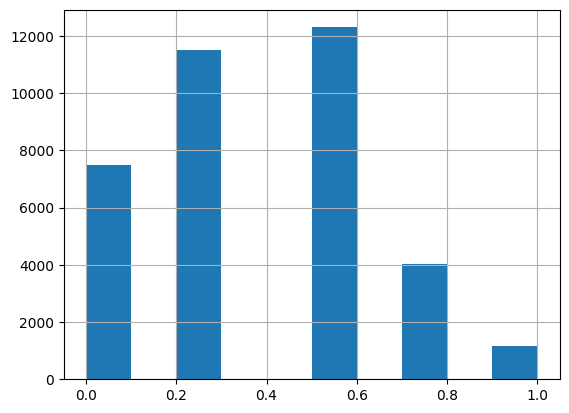

In [32]:
# Distribution of values of Score
df.score.hist()

In [33]:
# Items that were identical
df[df.score==1]

,id,anchor,target,context,score,input,section
28,473137168ebf7484,abatement,abating,F24,1.0,CONTEXT: F24; TEXT1: abatement; TEXT2: abating,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,CONTEXT: D01; TEXT1: absorbent properties; TEXT2: absorbent characteristics,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,CONTEXT: D01; TEXT1: absorbent properties; TEXT2: absorption properties,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,CONTEXT: B08; TEXT1: acid absorption; TEXT2: absorption of acid,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,CONTEXT: B08; TEXT1: acid absorption; TEXT2: acid absorption,B
...,...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,CONTEXT: F16; TEXT1: wiring trough; TEXT2: wiring troughs,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,CONTEXT: B05; TEXT1: wood article; TEXT2: wood articles,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,CONTEXT: B05; TEXT1: wood article; TEXT2: wooden article,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,CONTEXT: B44; TEXT1: wood article; TEXT2: wood article,B


## Training Model - Setup

In [34]:
# Constants for Training

# model
model_nm = 'microsoft/deberta-v3-small'

# tokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

# learning rate
lr = 8e-5

# batch size
bs = 128

# weight decay
wd = 0.01

# epochs
epochs = 4

In [35]:
# function that determines the split for validation and training data
# set a default validation dataset split percentage as 25%
# set a default training dataset split percentage as 75%
def get_dataSplit(vp):
  anchors = df.anchor.unique()
  print(f"Unique Anchors: {len(anchors)}")
  np.random.seed(42)
  np.random.shuffle(anchors)

  # specify how much validation set we want
  val_prop = vp
  val_sz = int(len(anchors)*val_prop)
  val_anchors = anchors[:val_sz]

  # Find which rows match the valid anchors and get their indices
  is_val = np.isin(df.anchor, val_anchors)
  idxs = np.arange(len(df))

  # Validation Data
  val_idxs = idxs[ is_val]
  print(f"Validation Dataset Length: {len(val_idxs)}")
  # Training Data
  trn_idxs = idxs[~is_val]
  print(f"Training Dataset Length: {len(trn_idxs)}")

  return (val_idxs, trn_idxs)

In [36]:
# Function to tokenize training data
def get_dds(df, vp=0.25):
  ds = Dataset.from_pandas(df).rename_column('score', 'label')
  print("Original Input Dataset")
  print(ds)
  eval_ds = Dataset.from_pandas(eval_df)
  print("Original Inference Dataset")
  print(eval_ds)
  inps = "anchor","target","context"
  tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('input','id','section'))
  print("Tokenized Input Dataset")
  print(tok_ds)
  print("Tokenized Inference Dataset")
  print(eval_ds)
  val_idxs, trn_idxs = get_dataSplit(vp)
  return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})


In [37]:
# Function to get the model
def get_model():
  return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

In [38]:
# Function to create a Trainer
# - Trainer -> class which combines the data and model together (similar to Learner in FastAI)
def get_trainer(dds, model=None):

    # initialize model
    if model is None: model = get_model()

    # Transformers require the TrainingArguments class to set up the arguments for the trainer
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')

    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr_d)

## Data Representation

### Combine Context + Anchor + Target Experiments

#### Method 1 - Baseline

In [39]:
# Method 1 - Baseline
df['input'] = 'CONTEXT: ' + df.context + '; TEXT1: ' + df.anchor + '; TEXT2: ' + df.target
eval_df['input'] = 'CONTEXT: ' + eval_df.context + '; TEXT1: ' + eval_df.anchor + '; TEXT2: ' + eval_df.target

dds = get_dds(df)

# create and train model
get_trainer(dds).train()


Original Input Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'section'],
    num_rows: 36473
})
Original Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Dataset
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Tokenized Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})
Unique Anchors: 733
Validation Dataset Length: 9116
Training Dataset Length: 27357


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026578,0.796921
2,No log,0.023371,0.818602
3,0.036700,0.024409,0.820100
4,0.036700,0.023927,0.819576


TrainOutput(global_step=856, training_loss=0.02694343183642236, metrics={'train_runtime': 217.0934, 'train_samples_per_second': 504.059, 'train_steps_per_second': 3.943, 'total_flos': 723683047099410.0, 'train_loss': 0.02694343183642236, 'epoch': 4.0})

#### Method 2 - Separate Token

In [40]:
# Method 2 - Separate Token
sep = tokz.sep_token
print(f"Separate Token: {sep}")
df['input'] = df.context + sep + df.anchor + sep + df.target
eval_df['input'] = eval_df.context + sep + eval_df.anchor + sep + eval_df.target

dds = get_dds(df)

# create and train model
get_trainer(dds).train()


Separate Token: [SEP]
Original Input Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'section'],
    num_rows: 36473
})
Original Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Dataset
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Tokenized Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})
Unique Anchors: 733
Validation Dataset Length: 9116
Training Dataset Length: 27357


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026330,0.792181
2,No log,0.025083,0.809545
3,0.032000,0.024699,0.812255
4,0.032000,0.024956,0.812318


TrainOutput(global_step=856, training_loss=0.024021479013924287, metrics={'train_runtime': 190.9271, 'train_samples_per_second': 573.14, 'train_steps_per_second': 4.483, 'total_flos': 468872298987930.0, 'train_loss': 0.024021479013924287, 'epoch': 4.0})

#### Method 3 - Change Token Separator

In [41]:
# Method 3 - change the type of separator
sep = " [s] "
df['input'] = df.context + sep + df.anchor + sep + df.target
eval_df['input'] = eval_df.context + sep + eval_df.anchor + sep + eval_df.target

dds = get_dds(df)

# create and train model
get_trainer(dds).train()


Original Input Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'section'],
    num_rows: 36473
})
Original Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Dataset
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Tokenized Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})
Unique Anchors: 733
Validation Dataset Length: 9116
Training Dataset Length: 27357


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027578,0.789799
2,No log,0.025510,0.814414
3,0.031600,0.023443,0.817882
4,0.031600,0.024294,0.817224


TrainOutput(global_step=856, training_loss=0.023982213479336177, metrics={'train_runtime': 197.7627, 'train_samples_per_second': 553.33, 'train_steps_per_second': 4.328, 'total_flos': 582121520370810.0, 'train_loss': 0.023982213479336177, 'epoch': 4.0})

#### Method 4 - Method 3 + Lowercase

In [42]:
# Method 4 - change to all lower case
df['input'] = df.context + sep + df.anchor + sep + df.target
df['input'] = df.input.str.lower()
eval_df['input'] = eval_df.context + sep + eval_df.anchor + sep + eval_df.target
eval_df['input'] = eval_df.input.str.lower()

dds = get_dds(df)
get_trainer(dds).train()

Original Input Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'section'],
    num_rows: 36473
})
Original Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Dataset
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Tokenized Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section'],
    num_rows: 36
})
Unique Anchors: 733
Validation Dataset Length: 9116
Training Dataset Length: 27357


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026599,0.794113
2,No log,0.024963,0.817053
3,0.031500,0.023034,0.818722
4,0.031500,0.024056,0.818191


TrainOutput(global_step=856, training_loss=0.02395056954054075, metrics={'train_runtime': 193.6779, 'train_samples_per_second': 565.0, 'train_steps_per_second': 4.42, 'total_flos': 582121520370810.0, 'train_loss': 0.02395056954054075, 'epoch': 4.0})

#### Method 5 - Special Tokens

In [43]:
# Method 5 - Special Tokens
df['sectok'] = '[' + df.section + ']'
eval_df['sectok'] = '[' + eval_df.section + ']'
sectoks = list(df.sectok.unique())
tokz.add_special_tokens({'additional_special_tokens': sectoks})

8

In [44]:
df['input'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target
eval_df['input'] = eval_df.sectok + sep + eval_df.context + sep + eval_df.anchor.str.lower() + sep + eval_df.target
dds = get_dds(df)

Original Input Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'section', 'sectok'],
    num_rows: 36473
})
Original Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section', 'sectok'],
    num_rows: 36
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Dataset
Dataset({
    features: ['label', 'sectok', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Tokenized Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section', 'sectok'],
    num_rows: 36
})
Unique Anchors: 733
Validation Dataset Length: 9116
Training Dataset Length: 27357


In [45]:
# resize embedding matrix in model
model = get_model()
model.resize_token_embeddings(len(tokz))

Embedding(128009, 768)

In [46]:
# train the model
trainer = get_trainer(dds, model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.029230,0.803785
2,No log,0.024406,0.821807
3,0.031400,0.023469,0.820734
4,0.031400,0.024289,0.820907


TrainOutput(global_step=856, training_loss=0.023841174406425976, metrics={'train_runtime': 214.1222, 'train_samples_per_second': 511.054, 'train_steps_per_second': 3.998, 'total_flos': 695370741753690.0, 'train_loss': 0.023841174406425976, 'epoch': 4.0})

In [47]:
# Train on the entire training dataset before doing final tests with inference dataset
def final_get_trainer(dds, model=None):
    # initialize model
    if model is None:
        model = get_model()

    # Transformers require the TrainingArguments class to set up the arguments for the trainer
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')

    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr_d)

In [48]:
dds = get_dds(df, 0.01)
trainer = final_get_trainer(dds, model=model)
trainer.train()

Original Input Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'input', 'section', 'sectok'],
    num_rows: 36473
})
Original Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section', 'sectok'],
    num_rows: 36
})


Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Tokenized Input Dataset
Dataset({
    features: ['label', 'sectok', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})
Tokenized Inference Dataset
Dataset({
    features: ['id', 'anchor', 'target', 'context', 'input', 'section', 'sectok'],
    num_rows: 36
})
Unique Anchors: 733
Validation Dataset Length: 347
Training Dataset Length: 36126


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.021583,0.836893
2,0.015400,0.019293,0.863323
3,0.015400,0.018774,0.860989
4,0.009500,0.018202,0.864261


TrainOutput(global_step=1132, training_loss=0.011905024835161943, metrics={'train_runtime': 272.1518, 'train_samples_per_second': 530.968, 'train_steps_per_second': 4.159, 'total_flos': 918764683369440.0, 'train_loss': 0.011905024835161943, 'epoch': 4.0})

## Evaluate Performance of Model on Inference Data

In [49]:
# Test model on the evaluation data
preds = trainer.predict(eval_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)
preds

array([[0.57763672],
       [0.57177734],
       [0.47412109],
       [0.34521484],
       [0.        ],
       [0.48852539],
       [0.51611328],
       [0.        ],
       [0.3503418 ],
       [0.64208984],
       [0.33959961],
       [0.28930664],
       [0.65234375],
       [0.71289062],
       [0.56591797],
       [0.37866211],
       [0.30786133],
       [0.05584717],
       [0.61181641],
       [0.4050293 ],
       [0.58447266],
       [0.26806641],
       [0.28491211],
       [0.29077148],
       [0.53857422],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.59912109],
       [0.35766602],
       [0.07025146],
       [0.68945312],
       [0.48779297],
       [0.41601562],
       [0.29858398]])

## Submission for Kaggle Competition

In [50]:
# Submit for kaggle competition
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1039

## Validation Set and Modeling Experiments

In [51]:
# Function to model
def f(x):
  return -3*x**2 + 2*x + 20

# Function for visualization Data
def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

Function we're trying to fit


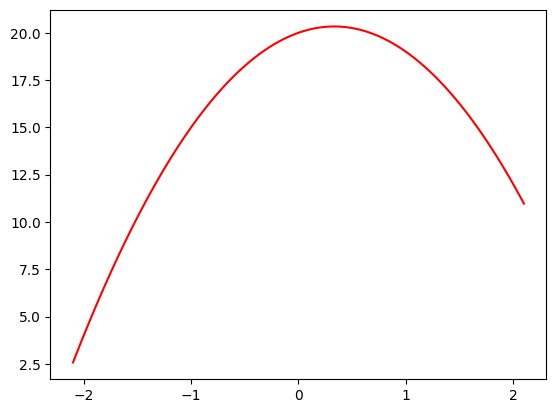

In [52]:
print(f"Function we're trying to fit")
plot_function(f)

In [53]:
# Functions for creating noisy data
from numpy.random import normal,seed,uniform
np.random.seed(42)

def noise(x, scale):
   return normal(scale=scale, size=x.shape)

def add_noise(x, mult, add):
  return x * (1+noise(x,mult)) + noise(x,add)

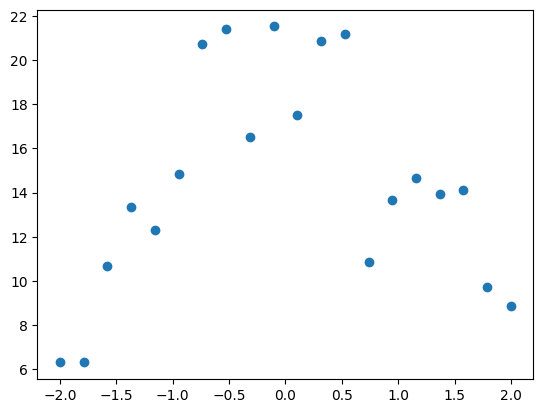

In [54]:
# Simulate Noisy Data
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [55]:
# Function for trying to find polynomial function that fits data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

Polynomial of Degree 1: Underfit


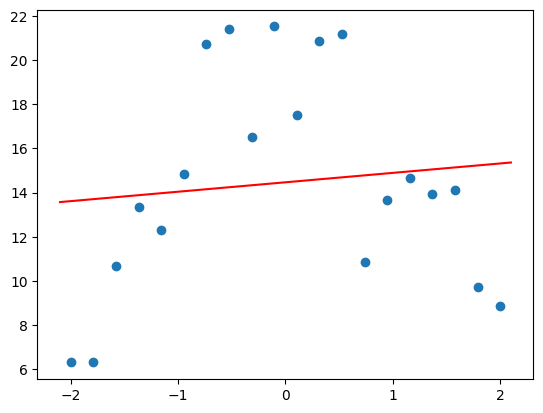

In [56]:
# Underfit
print(f"Polynomial of Degree 1: Underfit")
plot_poly(1)

Polynomial of Degree 10: Overfit


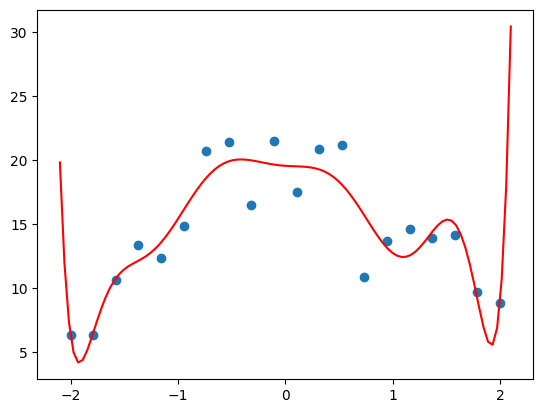

In [57]:
# Overfit
print(f"Polynomial of Degree 10: Overfit")
plot_poly(10)

Polynmomial of Degree 2: A close approximation of exact fit


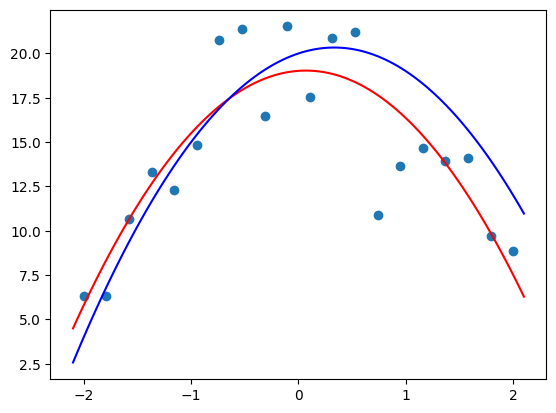

In [58]:
# Approximation of Close fit
print(f"Polynmomial of Degree 2: A close approximation of exact fit")
plot_poly(2)

# the original true function (one we're trying to fit)
plot_function(f, color='b')

## Metric Experiments: Correlation

In [59]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [60]:
# correlation coefficients for every combination of columns
np.set_printoptions(precision=2, suppress=True)
np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [61]:
# Correlation for two variables
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [62]:
# function for returning single coefficient correlation

def corr(x,y):
  return np.corrcoef(x,y)[0][1]

# test function
corr(housing.MedInc, housing.MedHouseVal)

# function for visualizing correlation between two variables
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')


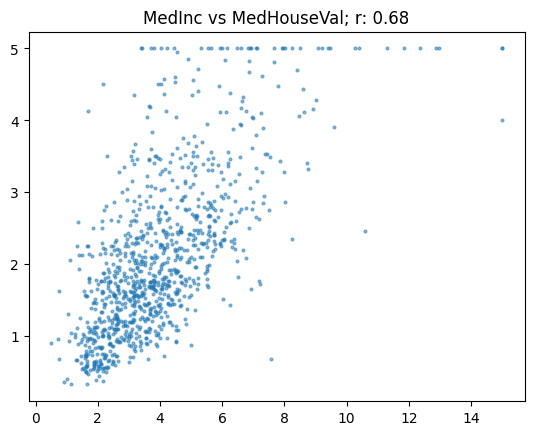

In [63]:
show_corr(housing, 'MedInc', 'MedHouseVal')

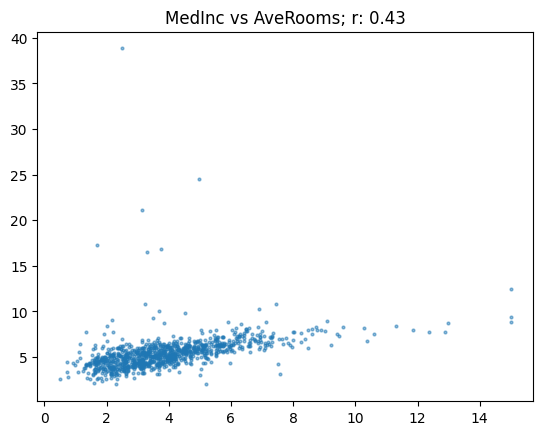

In [64]:
show_corr(housing, 'MedInc', 'AveRooms')

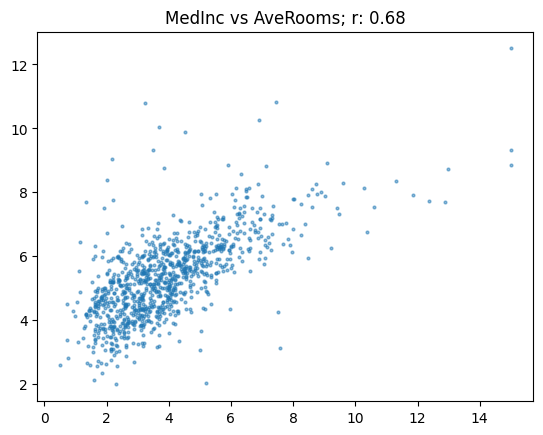

In [65]:
subset = housing[housing.AveRooms < 15]
show_corr(subset, 'MedInc', 'AveRooms')

## Resources

1. [FastAI Lesson 4](https://course.fast.ai/Lessons/lesson4.html)
2. [FastAI Chapter 10](https://nbviewer.org/github/fastai/fastbook/blob/master/10_nlp.ipynb)
3. [US Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/)
4. [Getting Started with NLP for Absolute Beginners](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)
5. [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/)
6. [How (and why) to create a good validation dataset](https://www.fast.ai/posts/2017-11-13-validation-sets.html)
7. [The problem with metrics is a big problem for AI](https://www.fast.ai/posts/2019-09-24-metrics.html)
8. [Utah CS 5340/6340 - Natural Language Processing](https://utah-intro-nlp.github.io/#calendar)
9. [Hugging Face Transformers docs](https://huggingface.co/docs/transformers/index)
10. [Jeremy Howard FastAI Live Coding](https://youtube.com/playlist?list=PLfYUBJiXbdtSLBPJ1GMx-sQWf6iNhb8mM&si=WwPOjgYofy4M9QUW)
11. [fast.ai docs](https://docs.fast.ai/)